<h1>Convolutional Neural Network</h1> 



<h3>Objective for this Notebook<h3>    
<h5> 1. Learn how to use a Convolutional Neural Network to classify handwritten digits from the MNIST database</h5>
<h5> 2. Learn how to reshape the images to make them faster to process </h5>     



<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer, and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>


<h2>Preparation</h2>


In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel 


In [3]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs. 


In [4]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  


In [5]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.


In [6]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Get the Data</h2> 


We create a transform to resize the image and convert it to a tensor.


In [8]:
IMAGE_SIZE = 16

# First the image is resized then converted to a tensor
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameter <code>train</code> to <code>True</code>. We use the transform defined above.


In [9]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Load the testing dataset by setting the parameter train to <code>False</code>.


In [11]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


Print out the fourth label 


In [12]:
# The label for the fourth data element

train_dataset[3][1]

1

Plot the fourth sample 


AttributeError: 'int' object has no attribute 'item'

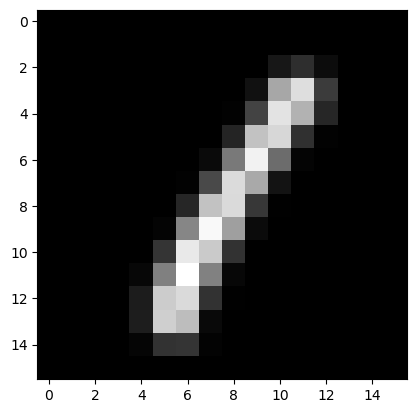

In [15]:
# The image for the fourth data element
show_data(train_dataset[3])

The fourth sample is a "1".


<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layers.

Channel Width can be calculated using the following formula

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/labs/Module4/Channel_Width.png)

Channel width must be calculated after each CNN layer and Max Pool layer.

Default Values CNN Layer:

Stride: 1
Padding: 0
Dilation: 1

Default Values Max Pool Layer:

Stride: Kernel Size
Padding: 0
Dilation: 1


In [16]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer, and Train the Model</h2> 


There are 16 output channels for the first layer, and 32 output channels for the second layer 


In [17]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.


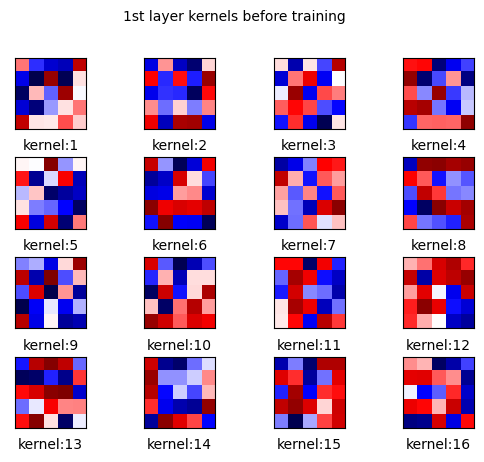

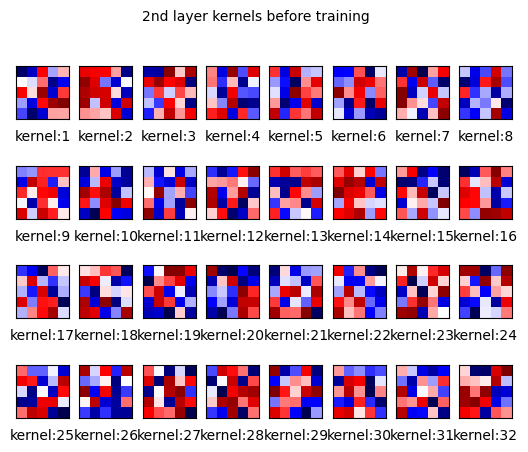

In [19]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer, and the dataset loader 


In [20]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [22]:
# Train the model

# Number of times we want to train on the taining dataset
n_epochs=3
# List to keep track of cost and accuracy
cost_list=[]
accuracy_list=[]
# Size of the validation dataset
N_test=len(validation_dataset)

# Model Training Function
def train_model(n_epochs):
    # Loops for each epoch
    for epoch in range(n_epochs):
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            z = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            COST+=loss.data
        
        # Saves cost of training data of epoch
        cost_list.append(COST)
        # Keeps track of correct predictions
        correct=0
        # Perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            # Makes a prediction
            z = model(x_test)
            # The class with the max value is the one we are predicting
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()
        
        # Calcualtes accuracy and saves it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


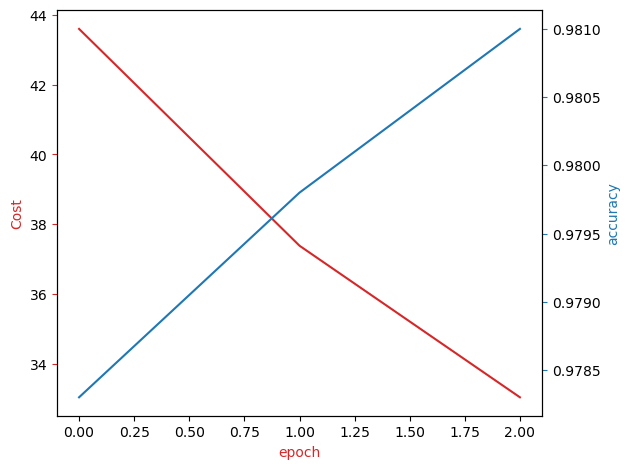

In [24]:
# Plot the Loss and Accuracy vs Epoch graph

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 


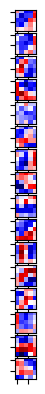

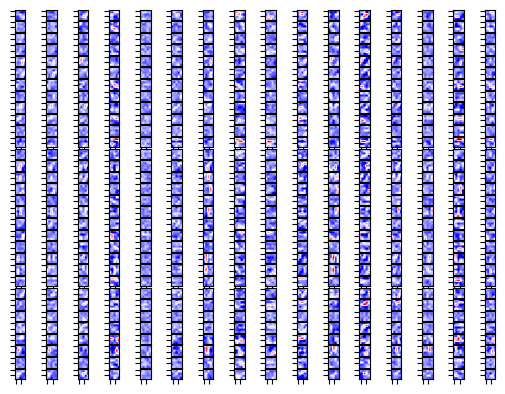

In [25]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 


AttributeError: 'int' object has no attribute 'item'

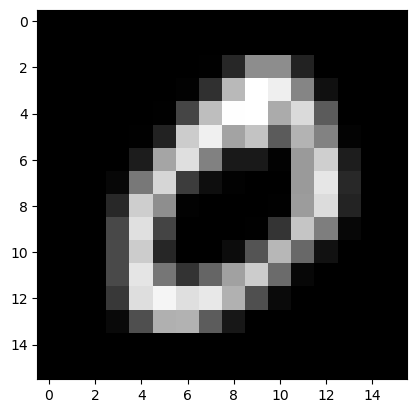

In [26]:
# Show the second image

show_data(train_dataset[1])

Determine the activations 


In [27]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 


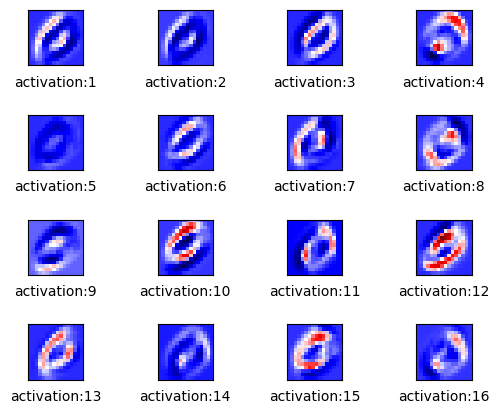

In [28]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 


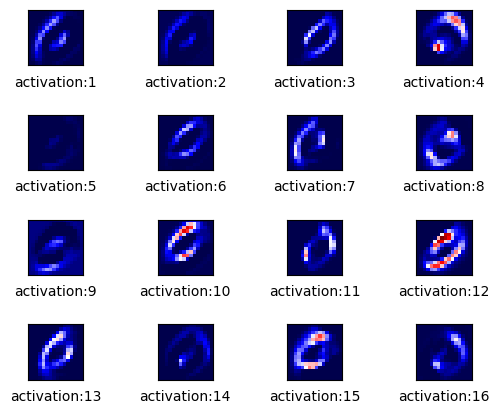

In [29]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.


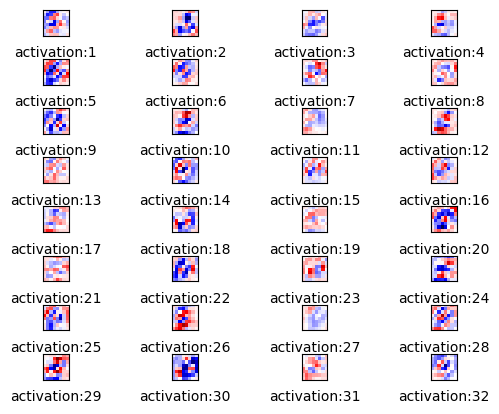

In [30]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu  


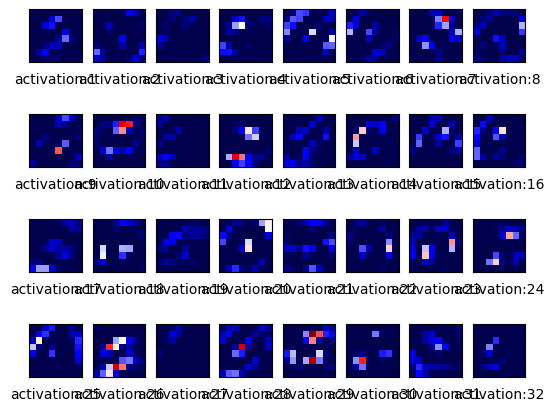

In [31]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

We can  see the result for the third sample 


AttributeError: 'int' object has no attribute 'item'

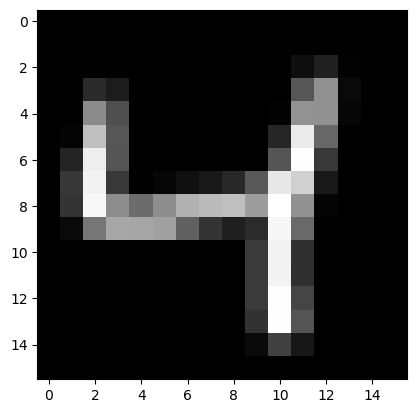

In [32]:
# Show the third image

show_data(train_dataset[2])

In [33]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

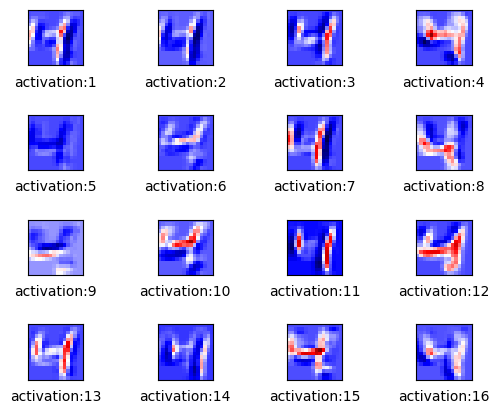

In [34]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

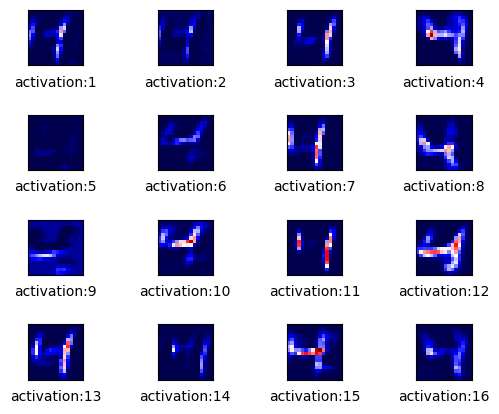

In [35]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

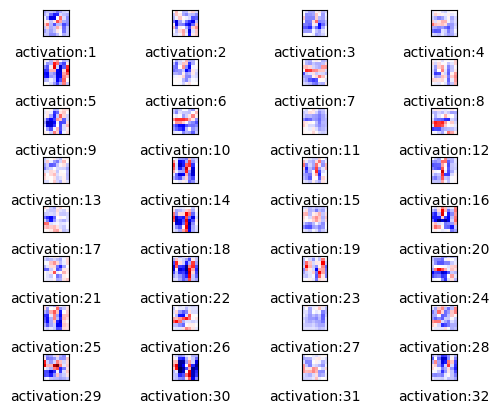

In [36]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

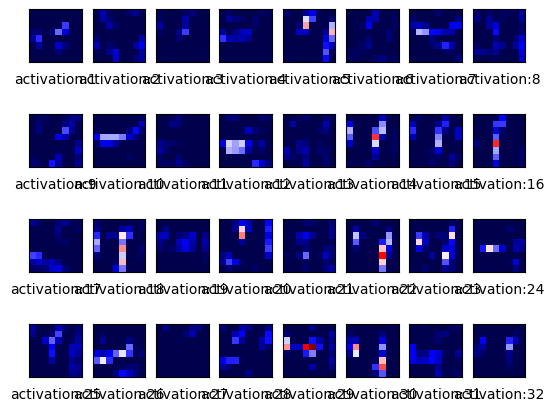

In [37]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plot the first five misclassified samples:


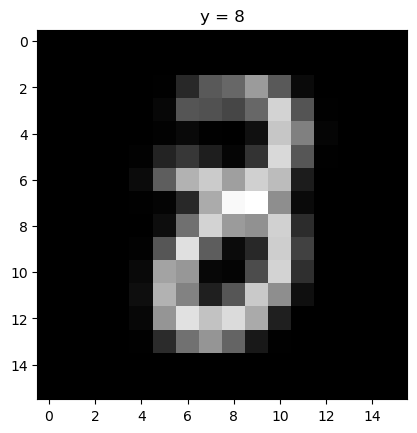

yhat:  tensor([3])


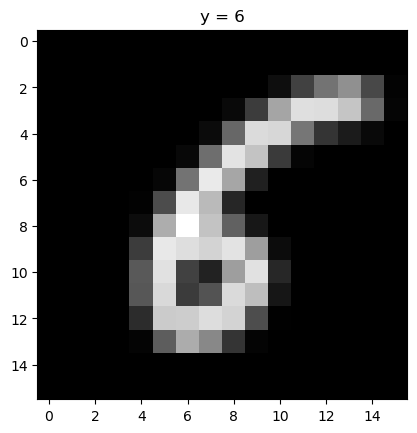

yhat:  tensor([5])


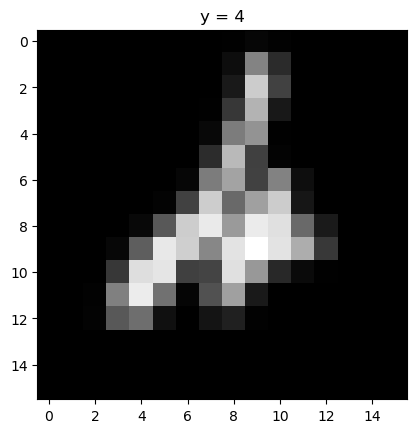

yhat:  tensor([2])


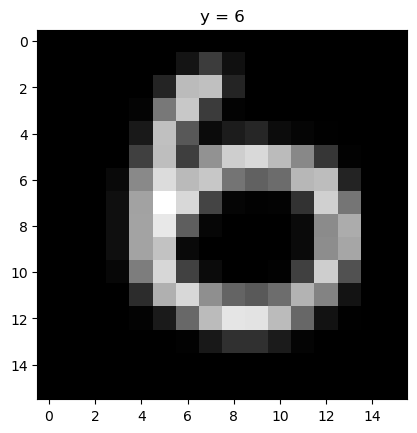

yhat:  tensor([0])


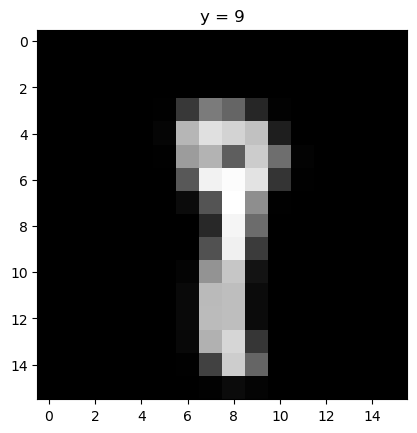

yhat:  tensor([1])


In [38]:
# Plot the misclassified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  